In [1]:
import pandas as pd
from scipy.stats import norm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

Dane - titanic

In [2]:
data = pd.read_csv('data/train.csv', index_col='PassengerId')
data.dropna(subset=['Pclass', 'Sex', 'Age'], inplace=True)
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


Wiek jako zbiory rozmyte

In [3]:
max_age = data['Age'].max()
age_range = np.linspace(0, int(max_age) + 1, int(max_age) + 1)
age_midpoint = 25
middle_age = norm.pdf(age_range, loc=age_midpoint, scale=5)
middle_age /= middle_age.max()
young_age = 1. - middle_age
young_age[age_midpoint:] = 0.
old_age = 1. - middle_age
old_age[:age_midpoint] = 0.

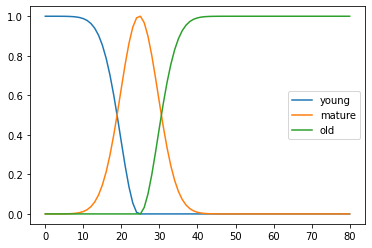

In [4]:
plt.plot(young_age, label='young')
plt.plot(middle_age, label='mature')
plt.plot(old_age, label='old')
plt.legend()

Zasady

In [5]:
def women_and_children_first(datapoint):
    z = 1.
    w = max(float(datapoint.Sex == 'female') * 0.5 + 0.25, young_age[int(datapoint.Age)])
    return z, w

def children_first(datapoint):
    z = 1.
    w = young_age[int(datapoint.Age)]
    return z, w

# def old_people_too(datapoint):
#     z = 1.
#     w = old_age[int(datapoint.Age)]
#     return z, w

def old_people_too(datapoint):
    z = .8
    w = old_age[int(datapoint.Age)]
    return z, w

# def young_adult_men_go_swimming(datapoint):
#     z = 0.
#     w = min(float(datapoint.Sex == 'male'), middle_age[int(datapoint.Age)])
#     return z, w

def adults_go_swimming(datapoint):
    z = 0.
    w = middle_age[int(datapoint.Age)]
    return z, w

def survival_paid_extra(datapoint):
    z = 1.5 - datapoint.Pclass / 2
    w = 1.
    return z, w

rules = [
    children_first,
    old_people_too,
    adults_go_swimming,
    survival_paid_extra
]

In [6]:
def assign_value(datapoint):
    pairs = [rule(datapoint) for rule in rules]
    values = np.array(list(zip(*pairs)))
    return (values[0] * values[1]).sum() / values[1].sum()

values = data.apply(assign_value, axis=1)

Metryki

In [21]:
threshold = 0.25

y_true = data['Survived']
y_pred = (values + ((data['Sex'] == 'female').astype(float) - .5) >= threshold).astype(int)

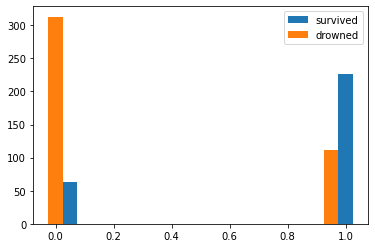

In [22]:
plt.hist(y_pred[y_true.astype(bool)], bins=20, align='right', label='survived')
plt.hist(y_pred[~y_true.astype(bool)], bins=20, align='left', label='drowned')
plt.legend()

In [23]:
print('accuracy:\t', accuracy_score(y_true, y_pred))
print('precision:\t', precision_score(y_true, y_pred))
print('recall:\t\t', recall_score(y_true, y_pred))
print('f1:\t\t', f1_score(y_true, y_pred))

accuracy:	 0.7563025210084033
precision:	 0.6715976331360947
recall:		 0.7827586206896552
f1:		 0.7229299363057324
